In [4]:
#import libraries
import math
import numpy as np
import pandas as pd
import ta
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from ta.utils import dropna


In [5]:
def read_csv(csv_path):
    data = pd.read_csv(csv_path)
    data = dropna(data)
    return data

In [6]:
data = read_csv('AMZN_daily.csv')
data.head()

,date,1. open,2. high,3. low,4. close,5. volume
0,2020-06-09,2529.44,2626.43,2525.00,2600.86,5097403.0
1,2020-06-08,2500.20,2530.00,2487.34,2524.06,3970654.0
2,2020-06-05,2444.51,2488.64,2437.13,2483.00,3306445.0
3,2020-06-04,2477.43,2507.54,2450.01,2460.60,2948710.0
4,2020-06-03,2468.01,2488.00,2461.17,2478.40,2671024.0


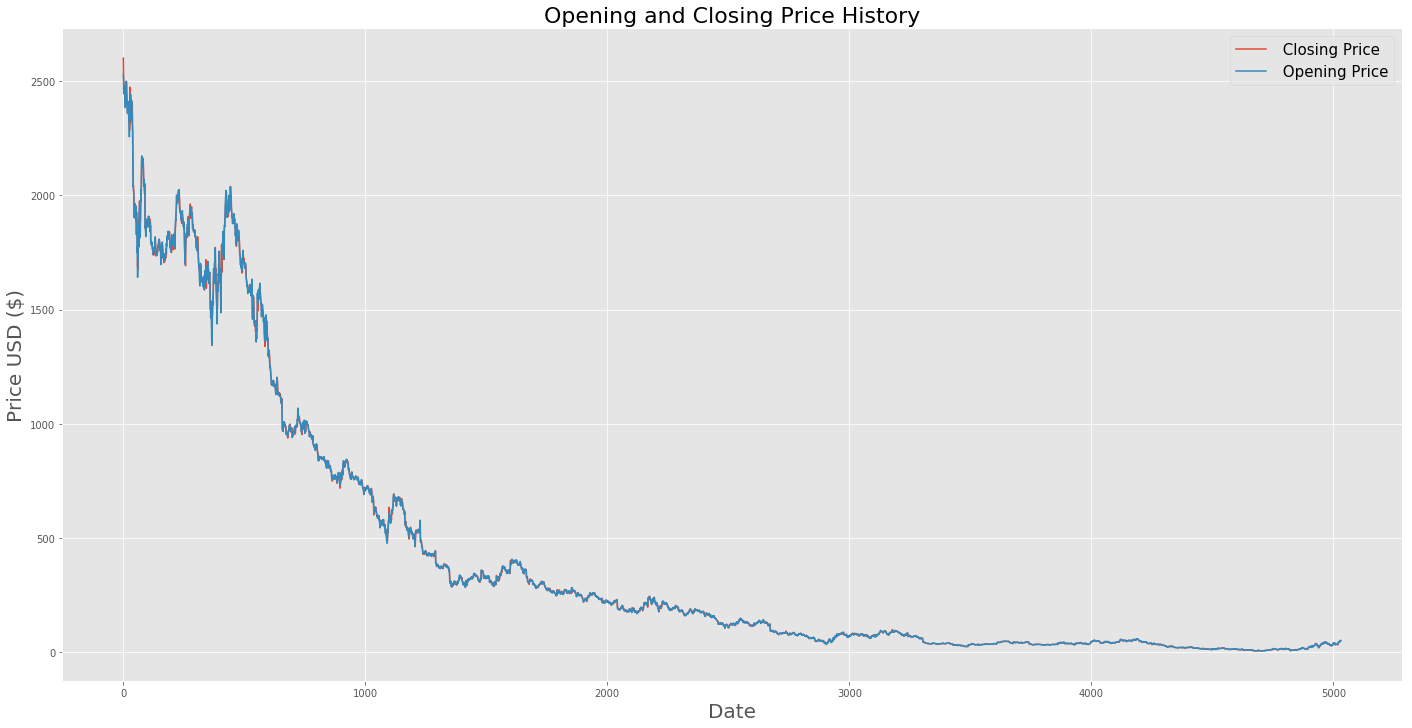

In [20]:
plt.style.use('ggplot')
plt.figure(figsize=(24,12))
plt.title('Opening and Closing Price History', fontsize=22)
plt.plot(data['4. close'], label=' Closing Price')
plt.plot(data['1. open'], label=' Opening Price')
plt.xlabel('Date',fontsize=20)
plt.ylabel('Price USD ($)',fontsize=20)
plt.legend(fontsize=15)
plt.show()

In [38]:
#Ectracting the data to be trained upon
close_data = data.filter(['4. close'])#,'5. volume'])
dataset = close_data.values
train_len = math.ceil(len(dataset)*0.85)
# train_len
close_data

array([[2600.86],
       [2524.06],
       [2483.  ],
       ...,
       [  48.44],
       [  52.19],
       [  51.88]])

In [26]:
#Normalising the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
# scaled_data
O_scaler = MinMaxScaler(feature_range=(0,1))
dataset[:,0].shape
scaled_output = O_scaler.fit_transform(np.reshape(dataset[:,0],(dataset.shape[0],1)))

In [27]:
history = 50 # number of data points to be used for prediction
train_data = scaled_data[0:train_len]
test_data = scaled_data[train_len-history:]
print(train_data.shape,test_data.shape)

(4278, 1) (804, 1)


In [28]:
# Creating the training data
x_train = []
y_train = []
for x in range(history,len(train_data)):
    x_train.append(train_data[x-history:x])
    y_train.append(train_data[x,0])
x_train,y_train = np.array(x_train),np.array(y_train)

x_test = []
for x in range(history,len(test_data)):
    x_test.append(test_data[x-history:x])
x_test = np.array(x_test)
y_test = dataset[train_len:,0]

y_train = np.reshape(y_train,(y_train.shape[0],1))
y_test = np.reshape(y_test,(y_test.shape[0],1))
y_train.shape

(4228, 1)

In [29]:
#Building the model
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1:])))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())

model.add(LSTM(units=56, return_sequences=False))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())

model.add(Dense(units=32))
# model.add(BatchNormalization())
model.add(Dense(units=1))

In [30]:
#Compile the model
model.compile(optimizer='adam', loss='mse')

In [31]:
history = model.fit(x_train, y_train, batch_size=1, epochs=30, validation_split = 0.05)

Train on 4016 samples, validate on 212 samples
Epoch 1/30
4016/4016 [==============================] - 71s 18ms/step - loss: 8.4523e-04 - val_loss: 5.4528e-06
Epoch 2/30
4016/4016 [==============================] - 73s 18ms/step - loss: 2.8594e-04 - val_loss: 0.0022
Epoch 3/30
4016/4016 [==============================] - 74s 18ms/step - loss: 2.5553e-04 - val_loss: 1.8662e-06
Epoch 4/30
4016/4016 [==============================] - 74s 18ms/step - loss: 1.9378e-04 - val_loss: 1.1809e-04
Epoch 5/30
4016/4016 [==============================] - 73s 18ms/step - loss: 1.7241e-04 - val_loss: 5.9420e-04
Epoch 6/30
4016/4016 [==============================] - 73s 18ms/step - loss: 1.2583e-04 - val_loss: 1.1522e-05
Epoch 7/30
4016/4016 [==============================] - 77s 19ms/step - loss: 1.3313e-04 - val_loss: 4.4016e-06
Epoch 8/30
4016/4016 [==============================] - 73s 18ms/step - loss: 1.2427e-04 - val_loss: 2.4492e-04
Epoch 9/30
4016/4016 [==============================] - 73s 1

In [32]:
predictions = model.predict(x_test)
predictions = O_scaler.inverse_transform(predictions)
y_test.shape

(754, 1)

In [33]:
#Find Error
real_mse = np.mean(np.square(y_test - predictions))
real_mse

2.019033355570248

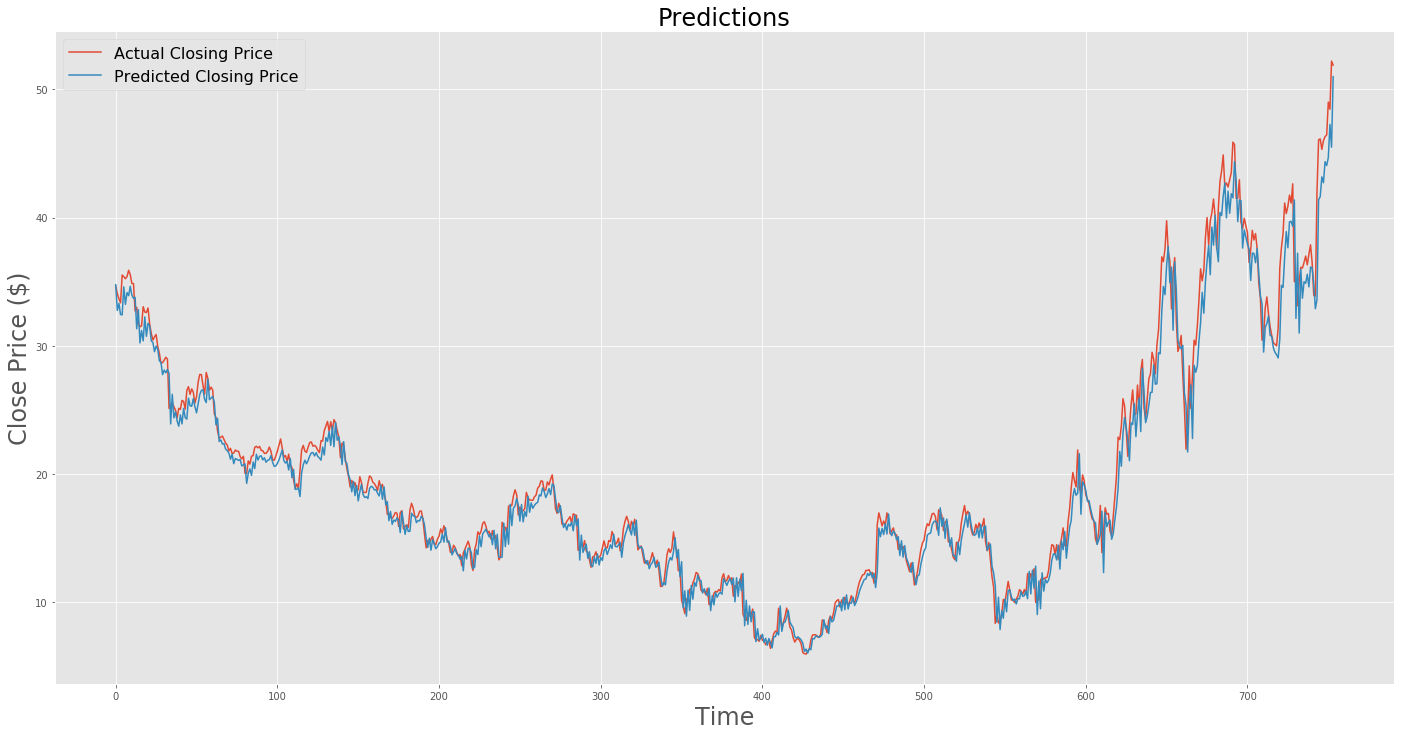

In [34]:
#plotting the results
ground_truth = np.array(close_data[train_len:])
ground_truth = np.expand_dims(ground_truth[:,0],-1)
plt.figure(figsize=(24,12))
plt.title('Predictions',fontsize = 24)
plt.xlabel('Time', fontsize=24)
plt.ylabel('Close Price ($)', fontsize=24)
plt.plot(ground_truth, label = "Actual Closing Price")
plt.plot(predictions, label = "Predicted Closing Price")
plt.legend(fontsize = 16)
plt.show()

In [35]:
model.save("AMZN_model.h5")
print("model saved")

model saved


In [34]:
#USing Technical Indicators
data['ADX'] = ta.trend.adx(data['2. high'], data['3. low'], data['4. close'], n = 20, fillna = True)
data['MACD'] = ta.trend.macd(data['4. close'], n_fast = 26 , n_slow = 12, fillna = True)
data.head()

,date,1. open,2. high,3. low,4. close,5. volume,ADX,MACD
0,2020-06-09,2529.44,2626.43,2525.00,2600.86,5097403.0,0.0,0.000000
1,2020-06-08,2500.20,2530.00,2487.34,2524.06,3970654.0,0.0,6.126496
2,2020-06-05,2444.51,2488.64,2437.13,2483.00,3306445.0,0.0,14.132081
3,2020-06-04,2477.43,2507.54,2450.01,2460.60,2948710.0,0.0,22.030108
4,2020-06-03,2468.01,2488.00,2461.17,2478.40,2671024.0,0.0,26.547023


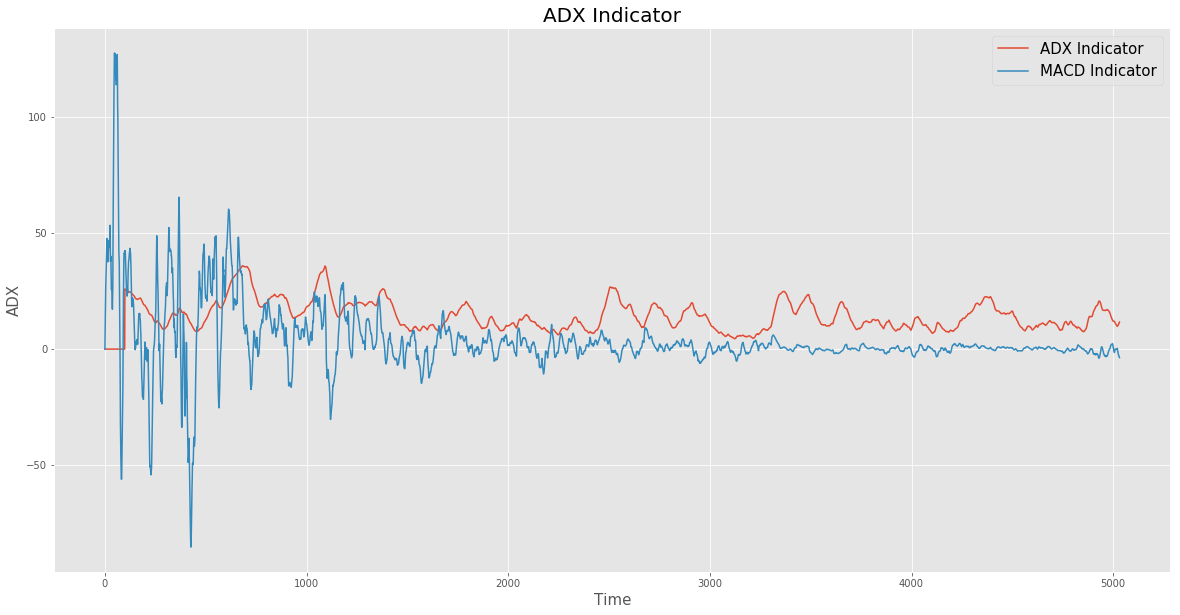

In [33]:
plt.figure(figsize = (20,10))
plt.title('ADX Indicator',fontsize = 20)
plt.plot(data['ADX'],label = 'ADX Indicator')
plt.plot(data['MACD'], label = 'MACD Indicator')
plt.xlabel('Time',fontsize = 15)
plt.ylabel('ADX',fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

In [42]:
#Scaling Technical Indicator
tech_ind_scaler = MinMaxScaler(feature_range=(0,1))
tech_ind_value = data.filter(['ADX']).values
scaled_tech_ind = tech_ind_scaler.fit_transform(tech_ind_value)
scaled_tech_ind

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.3464543 ],
       [0.37104003],
       [0.39323821]])